# Predict Immune Infiltration in Patients

In [45]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from msresist.figures.figure3 import plotPCA, plotR2YQ2Y, plotActualVsPredicted, plotScoresLoadings

### Import model

In [2]:
with open('msresist/data/pickled_models/binomial/CPTACmodel_BINOMIAL_CL24_W15_TMT2', 'rb') as p:
    model = pickle.load(p)[0]

In [114]:
centers = pd.DataFrame(model.transform())
X = pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:]
centers.columns = np.arange(model.ncl) + 1
centers["Patient_ID"] = X.columns[4:]
centers = centers.sort_values(by="Patient_ID")

### Import Immune Infiltration Data

In [115]:
y = pd.read_csv("msresist/data/MS/CPTAC/xCellSign_minimal.csv").sort_values(by="Patient ID").dropna(axis=1)
y = y[~y["Patient ID"].str.endswith(".N")]
li1 = list(y["Patient ID"])
li2 = list(centers["Patient_ID"])
dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
centers = centers.set_index("Patient_ID").drop(dif).reset_index()
assert all(centers["Patient_ID"].values == y["Patient ID"].values), "sampels not matching"

In [116]:
y.iloc[:, 1:] = StandardScaler().fit_transform(y.iloc[:, 1:])

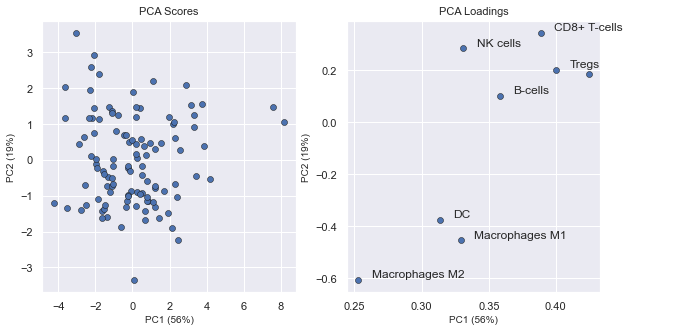

In [119]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
plotPCA(ax, y, 2, ["Patient ID"], "Cell Line", hue_scores=None, style_scores=None, style_load=None, legendOut=False)

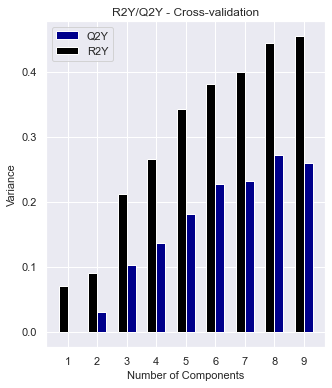

In [122]:
plsr = PLSRegression(n_components=2, scale=True)

_, ax = plt.subplots(1, 1, figsize=(5, 6))
plotR2YQ2Y(ax, plsr, centers, y, 10)

In [120]:
y = y.set_index("Patient ID")
centers = centers.set_index("Patient_ID")

In [132]:
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.metrics import r2_score

reg = MultiTaskLassoCV(cv=5).fit(centers, y)
r2_score(y, reg.predict(centers))

0.5139494913059677